In [1]:
import scipy as sp
import scipy.io.wavfile as wavfile
import os
import glob
import gmmhmm as hmm
import MFCC
import numpy as np
import re
import random
import pickle
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [2]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    states = []
    obs = []
    state = np.argmax(np.random.multinomial(1,gmmhmm[-1]))
    for i in range(n_sim):
        sample_component = np.argmax(np.random.multinomial(1, gmmhmm[1][state,:]))
        sample = np.random.multivariate_normal(gmmhmm[2][state, sample_component, :], gmmhmm[3][state, sample_component, :, :])
        states.append(state)
        obs.append(sample)
        state = np.argmax(np.random.multinomial(1, gmmhmm[0][:,state]))
    
    return np.array(states), np.array(obs)


In [3]:
A = np.array([[0.65,0.35],[0.15,0.85]]) # State transition matrix
pi = np.array([0.8,0.2]) # Initial state distribution
weights = np.array([[.7, .2, .1], [.1, .5, .4]])
means1 = np.array([[0., 17., -4.], [5., -12., -8.], [-16., 22., 2.]])
means2 = np.array([[-5., 3., 23.], [-12., -2., 14.], [15., -32., 0.]])
means = np.array([means1, means2])
covars1 = np.array([5*np.eye(3), 7*np.eye(3), np.eye(3)])
covars2 = np.array([10*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
covars = np.array([covars1, covars2])
gmmhmm = [A, weights, means, covars, pi]

In [4]:
samples = sample_gmmhmm(gmmhmm, 900)

In [5]:
pca = PCA(n_components=2)
pts = pca.fit_transform(samples[1])

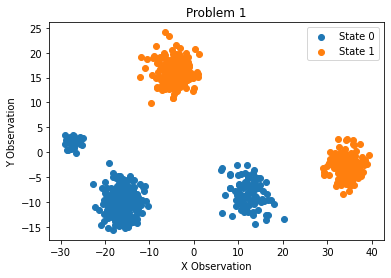

In [6]:
for color in [0,1]:
    mask = samples[0]==color
    plt.scatter(pts[mask,0], pts[mask,1], label='State ' + str(color))
    
plt.xlabel('X Observation')
plt.ylabel('Y Observation')
plt.title('Problem 1')
plt.legend()
plt.show()

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

In [7]:
files = []
path = 'Samples'
for filename in glob.glob(os.path.join(path, '*.wav')):
    w = wavfile.read(filename)[1]
    #d = w.readframes(w.getnframes())
    files.append(w)

/Users/quindaly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  after removing the cwd from sys.path.


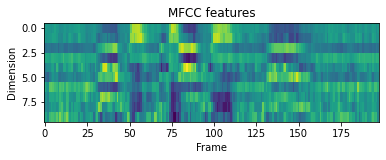

In [8]:
mfcc = []
for file in files:
    mfcc.append(MFCC.extract(file))

In [10]:
bio = mfcc[:30]
math = mfcc[30:60]
polisci = mfcc[60:90]
psych = mfcc[90:120]
stats = mfcc[120:150]

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [11]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [25]:
startprob, transmat = initialize(5)
model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
model.covars_prior = 0.01
model.fit(bio, init_params='mc', var=0.1)
print(model.logprob)


-56672.105616881796


In [41]:
# Partition each list of MFCCs into training sets of 20, test of 10
bio_train = bio[:20]
bio_test = bio[20:]
math_train = math[:20]
math_test = math[20:]
polisci_train = polisci[:20]
polisci_test = polisci[20:]
psych_train = psych[:20]
psych_test = psych[20:]
stats_train = stats[:20]
stats_test = stats[20:]

# Store best models:
dicts = [0,0,0,0,0]

In [42]:
i = 0
for subject in [bio_train, math_train, polisci_train, psych_train, stats_train]:
    
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    model.covars_prior = 0.01
    model.fit(subject, init_params='mc', var=0.1)
    dicts[i] = model
    i += 1
      

## Problem 4

Classify the 10 test samples for each word. Make a dictionary containing the accuracy
of the classification of your five testing sets where the words/phrases are the keys,
and the values are the percent accuracy.

Write a few sentences answering the following questions:
How does your system perform?
Which words are the hardest to correctly classify?

In [78]:
model_accuracies = {
    'biology': 0,
    'mathematics': 0,
    'political science': 0,
    'psychology': 0,
    'statistics': 0
}

In [61]:
# define each model for clarity
bio_model = dicts[0]
math_model = dicts[1]
polisci_model = dicts[2]
psych_model = dicts[3]
stats_model = dicts[4]

In [79]:
# Iterate through each model, testing each word against others
accuracies = []
correct = []
percentages = []
k = 0
for word_model in [bio_model, math_model, polisci_model, psych_model, stats_model]:
    for i in range(10):
        accuracies.append(word_model.score(bio_test[i]))
        accuracies.append(word_model.score(math_test[i]))
        accuracies.append(word_model.score(polisci_test[i]))
        accuracies.append(word_model.score(psych_test[i]))
        accuracies.append(word_model.score(stats_test[i]))
        
        # If the correct word is most likely, append 1
        if np.argmin(accuracies) == k:
            correct.append(1)
        else:
            correct.append(0)
            
        accuracies = []
    
    percentages.append(1-(sum(correct) / 10))
    correct = []
    # Increment word
    k += 1           
    
    
    

In [82]:
# Throw all of the accuracies into the dictionary

In [80]:
i = 0
keys = list(model_accuracies.keys())
for key in keys:
    model_accuracies[key] = percentages[i]
    i += 1

In [81]:
print(model_accuracies)

{'biology': 0.8, 'mathematics': 0.9, 'political science': 0.9, 'psychology': 0.7, 'statistics': 0.7}
